In [1]:
import numpy as np
import pandas as pd
import os
from collections import deque
from anytree import Node, RenderTree

from sklearn.tree import DecisionTreeRegressor
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn import tree

import matplotlib.pyplot as plt
import graphviz
import networkx as nx

# Exploratory data analysis 

In [2]:
DATA_PATH = os.path.join(os.pardir, 'Bluepack RH tab data_eBOM pakcage', 'Bluepack RH dataset')
df_bom_raw = pd.read_excel(os.path.join(DATA_PATH, '102041421_AB.xlsx'), 
                                 sheet_name='CM11 Report')
(df_bom_raw[df_bom_raw.Level=='.....5'])

,Level,Type,Name,Rev.,Item #,Brief Description,Status for valid rev,U/M,Quantity,Usage
66,.....5,ProE Drawing,87808-DFT,AD,NaN,"42"" DRIFT BAR",Released,NaN,0.0,Described By
67,.....5,Coating Specifications,CSP-106,AG,NaN,"CSP-106, 86% TUNGSTEN CARBIDE HIGH VELOCITY T...",Released,NaN,0.0,Reference Document
68,.....5,Instruction-Procedure,MN-15,AZ,NaN,PRODUCT IDENTIFICATION,Released,NaN,0.0,Reference Document
69,.....5,Welding Specifications,WPS-102D,AC,NaN,"WPS-102D, 4130, 80 KSI MIN YS, POSTWELD STRESS...",Released,NaN,0.0,Reference Document
70,.....5,Part SLB,87808-522-01000,AB,1.0,"DRIFT BAR HEAD, MDS-1",Released,EA,1.0,Uses
74,.....5,Part SLB,87808-622-01000,01,2.0,DRIFT BAR BODY,Released,EA,1.0,Uses
83,.....5,ProE Drawing,87808-522,AB,NaN,DRIFT BAR HEAD,Released,NaN,0.0,Described By
84,.....5,Material Specification List,MDS-1,AJ,NaN,"MDS-1, 4130/4140/4145 80 KSI 22 HRC MAX",Released,NaN,0.0,Reference Document
85,.....5,Instruction-Procedure,MN-15,AZ,NaN,PRODUCT IDENTIFICATION,Released,NaN,0.0,Reference Document
87,.....5,ProE Drawing,87808-622,AB,NaN,DRIFT BAR BODY,Released,NaN,0.0,Described By


In [3]:
# raw_df_data_dict = {}
all_parts = []
all_boms = []
all_products = []
files_converted = 0
files_not_converted = 0

for root, dirs, files in os.walk(DATA_PATH):
    if len(files) > 0:
        print('Converting .xlsx files from ', root)
        for file in sorted(files):
            if file[-5:] == '.xlsx':
                try:
                    print('Parsing file:', file)
                    file_name = file[:-5]                    
                    tab_name = file[:-8] 
                    df_parts_raw = pd.read_excel(
                        os.path.join(DATA_PATH, file),
                        sheet_name=1
                    )
                    df_bom_raw = pd.read_excel(
                        os.path.join(DATA_PATH, file),
                        sheet_name=2
                    )
                    all_parts.append(df_parts_raw)
                    all_boms.append(df_bom_raw)
                    all_products.append(tab_name)
                    files_converted += 1
                except Exception as err:
                    print('Error with file: ', file, ' : ', err)
                    files_not_converted += 1


Converting .xlsx files from  ../Bluepack RH tab data_eBOM pakcage/Bluepack RH dataset
Parsing file: 102041421_AB.xlsx
Parsing file: 102043250_AF.xlsx
Parsing file: 102055050_AC.xlsx
Parsing file: 102055845_AC.xlsx
Parsing file: 102103987_AG.xlsx
Parsing file: 102684662_AF.xlsx
Parsing file: 102689441_AD.xlsx
Parsing file: 102689450_AE.xlsx
Parsing file: 102727939_AC.xlsx
Parsing file: 102731362_AD.xlsx
Parsing file: 102731377_AD.xlsx
Parsing file: 102740546_AB.xlsx
Parsing file: 102743317_AD.xlsx
Parsing file: 102743322_AD.xlsx
Parsing file: 102749502_AG.xlsx
Parsing file: 102750404_AB.xlsx
Parsing file: 102779363_AD.xlsx
Parsing file: 102792167_AE.xlsx
Parsing file: 102825695_AC.xlsx
Parsing file: 102825802_AC.xlsx
Parsing file: 102832618_AD.xlsx
Parsing file: 102832791_AD.xlsx
Parsing file: 102849523_AC.xlsx
Parsing file: 102850902_AD.xlsx
Parsing file: 102869425_AC.xlsx
Parsing file: 102878398_AD.xlsx
Parsing file: 102883107_AC.xlsx
Parsing file: 102888683_AD.xlsx
Parsing file: 1028

In [4]:
common_parts = {}
for i in range(0,len(all_parts)):
    df_parts = all_parts[i]
    for part_name in df_parts.Name:
        if part_name not in common_parts:
            common_parts[part_name] = []
        common_parts[part_name].append(i)

common_bom_items = {}
for i in range(0,len(all_boms)):
#     df_bom = all_boms[i]
    for bom_part_name in all_boms[i].Name:
        if bom_part_name not in common_bom_items:
            common_bom_items[bom_part_name] = []
        common_bom_items[bom_part_name].append(i)

In [5]:
print(len(common_parts))
common_parts

473


{102040724: [0, 3],
 102040725: [0, 3],
 102934543: [0, 3, 34, 39],
 102044817: [0, 1, 2, 3, 4, 8, 11, 15, 18, 19, 34, 35, 36, 37, 39, 47, 62, 63],
 '87808-058-01000': [0, 2, 3, 8, 15, 34, 37, 39, 47, 49, 51, 52, 61],
 '16846-251': [0, 2, 3, 8, 15, 34, 37, 39, 47],
 101950598: [0, 2, 3, 8, 15, 34, 37, 39, 47],
 101950582: [0, 2, 3, 8, 15, 34, 37, 39, 47],
 101950557: [0, 2, 3, 8, 15, 34, 37, 39, 47],
 101941616: [0, 2, 3, 8, 15, 34, 37, 39, 47],
 102040723: [0, 3, 39],
 102040722: [0, 2, 3, 8, 15, 37, 39, 47],
 101884444: [0, 1, 2, 3, 4, 8, 11, 15, 18, 19, 34, 35, 36, 37, 39, 47, 62, 63],
 '16846-245-07000': [0, 2, 3, 15, 34, 37, 39, 47],
 101883463: [0, 2, 3, 8, 15, 34, 39],
 101941609: [0, 3, 39],
 101941612: [0, 3, 34, 39],
 101884445: [0, 2, 3, 15, 34, 37, 39, 47],
 101883468: [0,
  1,
  2,
  3,
  4,
  6,
  8,
  11,
  12,
  13,
  14,
  15,
  16,
  18,
  19,
  20,
  22,
  24,
  26,
  29,
  33,
  34,
  35,
  36,
  37,
  39,
  43,
  44,
  47,
  53,
  54,
  56,
  58,
  60,
  62,
  63,


In [6]:
print(len(common_bom_items))
common_bom_items

1112


{102041421: [0],
 '101950644': [0, 2, 3, 5, 5, 5, 5, 5, 8, 15, 34, 37, 39, 47],
 '101951193': [0, 2, 3, 5, 5, 5, 5, 5, 8, 15, 34, 37, 39, 47],
 'MN-15': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4

In [7]:
reference_name = '102044817'# '87808-058-01000'
for df_bom in all_boms:
    level = None
    print("{}-{}.xlsx".format(df_bom['Name'].iloc[0], df_bom['Rev.'].iloc[0]))
    for row in df_bom.itertuples():
        if row.Name == reference_name:
            level = row.Level
            print(list(row)[1:])
        elif level is not None:
            if len(row.Level) > len(level):
                print(list(row)[1:])
            else:
                level = None
                print("")

102041421-AB.xlsx
['..2', 'Part SLB', '102044817', 'AB', 27.0, 'SCREW, HOLLOW-LOCK SET, 5/16-18 UNC x 5/32, ALLOY STEEL', 'Released', 'EA', 3.0, 'Uses']
['...3', 'Instruction-Procedure', 'MN-15', 'AZ', nan, 'PRODUCT IDENTIFICATION', 'Released', nan, 0.0, 'Reference Document']

102043250-AF.xlsx
['..2', 'Part SLB', '102044817', 'AB', 27.0, 'SCREW, HOLLOW-LOCK SET, 5/16-18 UNC x 5/32, ALLOY STEEL', 'Released', 'EA', 3.0, 'Uses']
['...3', 'Instruction-Procedure', 'MN-15', 'AZ', nan, 'PRODUCT IDENTIFICATION', 'Released', nan, 0.0, 'Reference Document']

102055050-AC.xlsx
['..2', 'Part SLB', '102044817', 'AB', 27.0, 'SCREW, HOLLOW-LOCK SET, 5/16-18 UNC x 5/32, ALLOY STEEL', 'Released', 'EA', 3.0, 'Uses']
['...3', 'Instruction-Procedure', 'MN-15', 'AZ', nan, 'PRODUCT IDENTIFICATION', 'Released', nan, 0.0, 'Reference Document']

102055845-AC.xlsx
['..2', 'Part SLB', '102044817', 'AB', 27.0, 'SCREW, HOLLOW-LOCK SET, 5/16-18 UNC x 5/32, ALLOY STEEL', 'Released', 'EA', 3.0, 'Uses']
['...3', 'Ins

In [8]:
common_bom_items['87808-058-01000']
# all_boms[0][['Name', 'Rev.']].iloc[0]

[0,
 0,
 0,
 2,
 2,
 2,
 3,
 3,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 8,
 8,
 15,
 15,
 15,
 34,
 34,
 37,
 37,
 37,
 39,
 39,
 39,
 47,
 47,
 47,
 49,
 49,
 51,
 51,
 52,
 52,
 52,
 61,
 61]

In [9]:
# build a tree from bom
def bom2tree(df):
    parents = deque()
    level = ''
    for row in df.itertuples():
        cur_node = Node(name=row.Name)
        if len(row.Level) > len(level):
            if len(parents) > 0:
                parents.append(prev_node)
                cur_node.parent = parents[-1]
            else:
                parents.append(cur_node)
            level = row.Level
        elif len(row.Level) == len(level):
            cur_node.parent = parents[-1]
        else:
            for i in range(0, len(level)-len(row.Level)):
                parents.pop()
            cur_node.parent = parents[-1]
            level = row.Level
        prev_node = cur_node
    return parents[0]

In [10]:
# test bom2tree function
root = bom2tree(all_boms[0])
for pre, fill, node in RenderTree(root):
    print("{}{}".format(pre, node.name))

102041421
├── 101950644
│   ├── 101951193
│   ├── MN-15
│   ├── 101950557
│   │   ├── 101936526
│   │   ├── CSP-16
│   │   ├── MDS-4
│   │   └── MN-15
│   ├── 101950598
│   │   ├── 101936528
│   │   ├── CSP-16
│   │   ├── MDS-4
│   │   └── MN-15
│   └── 101950582
│       ├── 101936527
│       ├── CSP-16
│       ├── MDS-4
│       └── MN-15
├── 102019125
│   ├── MN-15
│   ├── 101950584
│   │   ├── 101936532
│   │   ├── CSP-16
│   │   ├── MDS-4
│   │   └── MN-15
│   └── 16846-245-07000
│       ├── 103092000
│       ├── 16846-ORG
│       └── CNMS-E2100
├── 102040733
├── 102043265
│   ├── 102043464
│   ├── CSP-16
│   ├── MDS-4
│   └── MN-15
├── 102072338
├── 102077867
├── 102673645
├── 87808-058-01000
│   ├── 87808-DFT
│   ├── CSP-106
│   ├── MN-15
│   ├── WPS-102D
│   ├── 87808-522-01000
│   │   ├── 87808-522
│   │   ├── MDS-1
│   │   └── MN-15
│   └── 87808-622-01000
│       ├── 87808-622
│       └── MDS-1
├── CSP-99
├── MN-15
├── 101919765
│   ├── 101919767
│   ├── CSP-28
│   ├── CSP-85


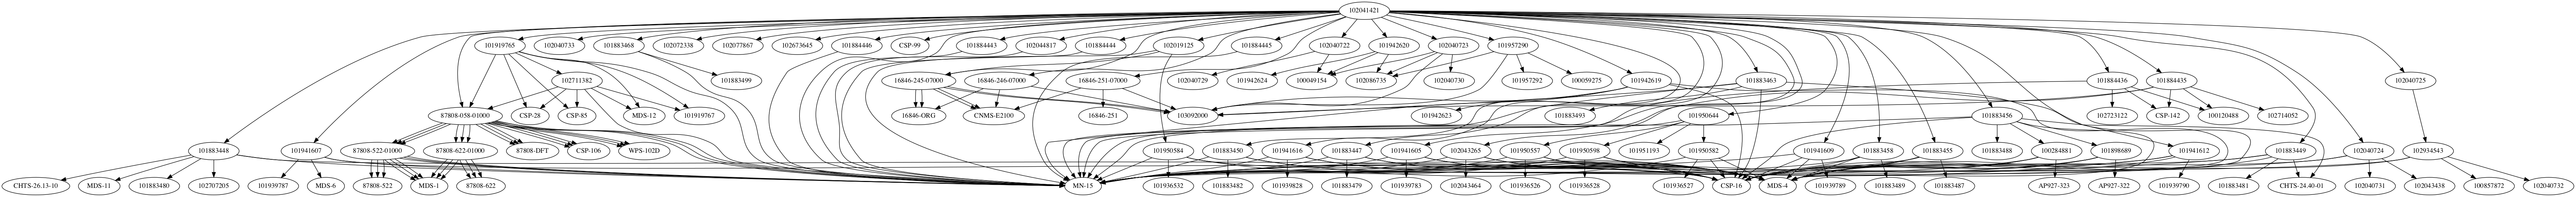

In [11]:
# graph of BOM parts 
from anytree.dotexport import RenderTreeGraph
RenderTreeGraph(root).to_picture("tree.png")
from IPython.display import Image, display
display(Image(filename="tree.png"))

# Prepare training and test data

In [12]:
# Parsing complex columns
def parse_dep_params(old_ser_name, new_ser_names, df):
    old_ser = df[old_ser_name, 'value']
    new_sers = {new_ser_names[0]: old_ser.str.findall(r'.+\[').map(lambda x: x[0]).str.replace('[', '').str.replace(']', ''),
                new_ser_names[1]: old_ser.str.findall(r'\[\d+\]').map(lambda x: x[0]).str.replace('[', '').str.replace(']', '')}

    for ser_name, ser in new_sers.items():
        df[old_ser_name, ser_name] = ser
        
    df = df.sort_index(axis=1)
    return df


def parse_range_params(old_ser_name, new_ser_names, df):
    old_ser = df[old_ser_name, 'value']
    new_sers_arr = old_ser.str.split('-')
    
    new_sers = {}
    
    for i, ser_name in enumerate(new_ser_names):
        new_sers[ser_name] = new_sers_arr.map(lambda x: x[i])  
    
    for ser_name, ser in new_sers.items():
        df[old_ser_name, ser_name] = ser
        
    df = df.sort_index(axis=1)
    return df

def parse_list_params(old_ser_name, new_ser_names, df):
    old_ser = df[old_ser_name, 'value']
    new_sers_arr = old_ser.str.split(',')
    
    new_sers = {}
    
    for i, ser_name in enumerate(new_ser_names):
        new_sers[ser_name] = new_sers_arr.map(lambda x: x[i])    

    for ser_name, ser in new_sers.items():
        df[old_ser_name, ser_name] = ser
        
    df = df.sort_index(axis=1)
    return df

In [13]:
# load dataset
df_attr = pd.read_csv(
    'independent_attributes_df.tsv', 
    sep='\t', 
#     index_col=0
)
df_attr.rename(columns={'Unnamed: 0': 'name'}, inplace=True)
# remove underscore and two letter revision
df_attr['name'] = df_attr['name'].apply(lambda x: x[:-3])
df_attr = df_attr.set_index('name')
print(df_attr.info())

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 103180915 to 102779363
Data columns (total 19 columns):
ACTIVE FLOW WETTED MATERIAL - YIELD STRENGTH (KSI)              66 non-null object
CASING SIZE (IN)                                                66 non-null object
CASING WEIGHT RANGE (PPF)                                       66 non-null object
CERTIFICATION STATUS                                            64 non-null object
DIFFERENTIAL PRESSURE RATING (PSI)                              64 non-null float64
EXTERNAL WORKING PRESSURE (PSI) - EOEC AT SPECIFIED TEMP (F)    66 non-null object
I.D. - DRIFT (IN)                                               66 non-null float64
INTERNAL WORKING PRESSURE (PSI) - EOEC AT SPECIFIED TEMP (F)    66 non-null object
LOWER THREAD CONNECTING - SIZE (IN), WT (PPF), TYPE, CONFIG     66 non-null object
MATERIAL/ELEMENTS                                               64 non-null object
MATERIAL/O-RING(S)                                     

In [14]:
# Parsing complex columns
ia_df_parsed = df_attr.copy()
each_attr_cols = ['value']
old_cols = list(df_attr.columns)
new_cols = []
new_cols = pd.MultiIndex.from_product([old_cols, each_attr_cols], names=['attributes', 'values'])
ia_df_parsed.columns = new_cols

old_ser_name = 'ACTIVE FLOW WETTED MATERIAL - YIELD STRENGTH (KSI)'
new_ser_names = ['ACTIVE FLOW WETTED MATERIAL', 'YIELD STRENGTH (KSI)']
ia_df_parsed = parse_dep_params(old_ser_name, new_ser_names, ia_df_parsed)

old_ser_name = 'EXTERNAL WORKING PRESSURE (PSI) - EOEC AT SPECIFIED TEMP (F)'
new_ser_names = ['EXTERNAL WORKING PRESSURE (PSI)', 'EOEC AT SPECIFIED TEMP (F)']
ia_df_parsed.loc[ia_df_parsed[old_ser_name, 'value'] == '6000', (old_ser_name, 'value')] = '6000[0]'
ia_df_parsed = parse_dep_params(old_ser_name, new_ser_names, ia_df_parsed)

old_ser_name = 'INTERNAL WORKING PRESSURE (PSI) - EOEC AT SPECIFIED TEMP (F)'
new_ser_names = ['INTERNAL WORKING PRESSURE (PSI)', 'EOEC AT SPECIFIED TEMP (F)']
ia_df_parsed.loc[ia_df_parsed[old_ser_name, 'value'] == '7500', (old_ser_name, 'value')] = '7500[0]'
ia_df_parsed = parse_dep_params(old_ser_name, new_ser_names, ia_df_parsed)

old_ser_name = 'TENSILE STRENGTH (LBS) - EOEC AT SPECIFIED TEMP (F)'
new_ser_names = ['TENSILE STRENGTH (LBS)', 'EOEC AT SPECIFIED TEMP (F)']
ia_df_parsed.loc[ia_df_parsed[old_ser_name, 'value'] == '324,890', (old_ser_name, 'value')] = '324890[0]'
ia_df_parsed = parse_dep_params(old_ser_name, new_ser_names, ia_df_parsed)

old_ser_name = 'CASING WEIGHT RANGE (PPF)'
new_ser_names = ['MIN', 'MAX']
ia_df_parsed = parse_range_params(old_ser_name, new_ser_names, ia_df_parsed)

old_ser_name = 'UPPER THREAD CONNECTING - SIZE (IN), WT (PPF), TYPE, CONFIG'
new_ser_names = ['SIZE (IN)', 'WT (PPF)', 'TYPE', 'CONFIG']
ia_df_parsed = parse_list_params(old_ser_name, new_ser_names, ia_df_parsed)

old_ser_name = 'LOWER THREAD CONNECTING - SIZE (IN), WT (PPF), TYPE, CONFIG'
new_ser_names = ['SIZE (IN)', 'WT (PPF)', 'TYPE', 'CONFIG']
ia_df_parsed = parse_list_params(old_ser_name, new_ser_names, ia_df_parsed)

casing_inches = {'7':7, 
 '6-5/8':6.625, 
 '4-1/2':4.5, 
 '9-5/8':9.625, 
 '10-3/4':10.75, 
 '5-1/2':5.5}
ia_df_parsed['CASING SIZE (IN)', 'value'] = ia_df_parsed['CASING SIZE (IN)', 'value'].map(casing_inches)

service_nace = {'YES':True, 'NO':False}
ia_df_parsed['SERVICE NACE (YES/NO)', 'value'] = ia_df_parsed['SERVICE NACE (YES/NO)', 'value'].map(service_nace)

# remove original complex columns
ia_df_parsed = ia_df_parsed.drop(columns=[
    ('ACTIVE FLOW WETTED MATERIAL - YIELD STRENGTH (KSI)', 'value'), 
    ('EXTERNAL WORKING PRESSURE (PSI) - EOEC AT SPECIFIED TEMP (F)', 'value'),
    ('INTERNAL WORKING PRESSURE (PSI) - EOEC AT SPECIFIED TEMP (F)', 'value'),
    ('TENSILE STRENGTH (LBS) - EOEC AT SPECIFIED TEMP (F)', 'value'),
    ('CASING WEIGHT RANGE (PPF)', 'value'),
    ('UPPER THREAD CONNECTING - SIZE (IN), WT (PPF), TYPE, CONFIG', 'value'),
    ('LOWER THREAD CONNECTING - SIZE (IN), WT (PPF), TYPE, CONFIG', 'value'),
])

# rename multipart columns
ia_df_parsed = ia_df_parsed.rename(columns={
    'ACTIVE FLOW WETTED MATERIAL - YIELD STRENGTH (KSI)': 'ACTIVE FLOW WETTED MATERIAL', 
    'EXTERNAL WORKING PRESSURE (PSI) - EOEC AT SPECIFIED TEMP (F)': 'EXTERNAL WORKING PRESSURE',
    'INTERNAL WORKING PRESSURE (PSI) - EOEC AT SPECIFIED TEMP (F)': 'INTERNAL WORKING PRESSURE',
    'LOWER THREAD CONNECTING - SIZE (IN), WT (PPF), TYPE, CONFIG': 'LOWER THREAD CONNECTING',
    'TENSILE STRENGTH (LBS) - EOEC AT SPECIFIED TEMP (F)': 'TENSILE STRENGTH', 
    'UPPER THREAD CONNECTING - SIZE (IN), WT (PPF), TYPE, CONFIG': 'UPPER THREAD CONNECTING'
})

# set data types
ia_df_parsed = ia_df_parsed.apply(pd.to_numeric, errors='ignore')

ia_df_parsed.head()

attributes ACTIVE FLOW WETTED MATERIAL                      CASING SIZE (IN)  \
values     ACTIVE FLOW WETTED MATERIAL YIELD STRENGTH (KSI)            value   
name                                                                           
103180915                         41XX                   80            9.625   
102825695                         13CR                   80            6.625   
102749502                         41XX                   80            7.000   
102743322                         41XX                   80            7.000   
103197963                         41XX                   80            9.625   

attributes CASING WEIGHT RANGE (PPF)             CERTIFICATION STATUS  \
values                           MAX   MIN                      value   
name                                                                    
103180915                       47.0  40.0           ISO-V3[150-325F]   
102825695                       28.0  24.0  ISO-V3[150-325F, 40-235F]   
102749502                       29.0  23.0           ISO-V3[150-325F]   
102743322                       32.0  26.0           ISO-V3[150-325F]   
103197963                       47.0  40.0           ISO-V3[150-325F]   

attributes DIFFERENTIAL PRESSURE RATING (PSI)  EXTERNAL WORKING PRESSURE  \
values                                  value EOEC AT SPECIFIED TEMP (F)   
name                                                                       
103180915                              5000.0                        325   
102825695                              5000.0                        325   
102749502                              5000.0                        325   
102743322                              5000.0                        325   
103197963                              5000.0                        325   

attributes                                 I.D. - DRIFT (IN)  ...  \
values     EXTERNAL WORKING PRESSURE (PSI)             value  ...   
name                                                          ...   
103180915                             5000             3.833  ...   
102825695                             5000             2.867  ...   
102749502                             5000             2.867  ...   
102743322                             5000             2.867  ...   
103197963                             5000             3.833  ...   

attributes QUALITY CONTROL PLAN - QCP SERVICE NACE (YES/NO)  \
values                          value                 value   
name                                                          
103180915           CLG QCP-102817386                  True   
102825695           CLG QCP-102817386                  True   
102749502           CLG QCP-102817386                  True   
102743322           CLG QCP-102817386                  True   
103197963           CLG QCP-102817386                  True   

attributes SETTING DIFFERENTIAL PRESSURE - RECOMMENDED (MIN)(PSI)  \
values                                                      value   
name                                                                
103180915                                              3000.0       
102825695                                              3000.0       
102749502                                              3000.0       
102743322                                              3000.0       
103197963                                              3000.0       

attributes SHEAR RELEASE FORCE (LB)           TENSILE STRENGTH  \
values                        value EOEC AT SPECIFIED TEMP (F)   
name                                                             
103180915                  116766.0                        325   
102825695                  116766.0                        325   
102749502                  103792.0                        325   
102743322                  103792.0                        325   
103197963                  116766.0                        325   

attributes               

In [15]:
# append structure data to the dataset
for part in common_parts:
    d = {all_products[id]: True for id in common_parts[part]}
    ia_df_parsed.insert(len(ia_df_parsed.columns), part, pd.Series(d))

print("")
ia_df_parsed.info()
# df_attr.to_csv('indep_attr_and_structure.tsv', sep='\t')


<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 103180915 to 102779363
Columns: 503 entries, (ACTIVE FLOW WETTED MATERIAL, ACTIVE FLOW WETTED MATERIAL) to (100436734, )
dtypes: bool(1), float64(12), int64(7), object(483)
memory usage: 259.4+ KB


In [16]:
# find most common parts in all 66 packers
part_frequency = {}
for part in common_parts:
    part_frequency[part] = len(common_parts[part])
part_frequency

part_frequency_count = {}
top_parts = []
for key, value in sorted(part_frequency.items(), key=lambda kv: kv[1], reverse=True):
    if value not in part_frequency_count:
        part_frequency_count[value] = 0
    part_frequency_count[value] += 1
    top_parts.append(key)
    print("{}: {} {}".format(key, value, common_parts[key]))
part_frequency_count

101883468: 38 [0, 1, 2, 3, 4, 6, 8, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 26, 29, 33, 34, 35, 36, 37, 39, 43, 44, 47, 53, 54, 56, 58, 60, 62, 63, 64, 65]
87808-700-00005: 33 [1, 5, 9, 10, 11, 12, 13, 14, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 40, 41, 43, 45, 46, 48, 55, 56, 58, 65]
102689394: 28 [5, 7, 9, 10, 17, 21, 23, 25, 27, 28, 30, 31, 32, 38, 40, 41, 42, 45, 46, 48, 49, 50, 51, 52, 55, 57, 59, 61]
102872569: 27 [5, 9, 10, 17, 21, 23, 25, 27, 28, 30, 31, 32, 38, 40, 41, 42, 45, 46, 48, 49, 50, 51, 52, 55, 57, 59, 61]
101986057: 27 [5, 9, 10, 17, 21, 23, 25, 27, 28, 30, 31, 32, 38, 40, 41, 42, 45, 46, 48, 49, 50, 51, 52, 55, 57, 59, 61]
102876648: 27 [5, 9, 10, 17, 21, 23, 25, 27, 28, 30, 31, 32, 38, 40, 41, 42, 45, 46, 48, 49, 50, 51, 52, 55, 57, 59, 61]
103157980: 27 [5, 9, 10, 17, 21, 23, 25, 27, 28, 30, 31, 32, 38, 40, 41, 42, 45, 46, 48, 49, 50, 51, 52, 55, 57, 59, 61]
16846-365: 26 [5, 9, 10, 17, 21, 23, 25, 27, 28, 30, 31, 32, 38, 40, 41, 42, 46, 4

{38: 1,
 33: 1,
 28: 1,
 27: 4,
 26: 1,
 22: 1,
 20: 13,
 19: 2,
 18: 16,
 16: 5,
 15: 2,
 14: 2,
 13: 11,
 11: 2,
 10: 2,
 9: 23,
 8: 6,
 7: 9,
 6: 20,
 5: 14,
 4: 50,
 3: 61,
 2: 79,
 1: 147}

# Create decision tree models

Accuracy (max depth=2): 0.66 (+/- 0.13)
Accuracy (max depth=5): 0.86 (+/- 0.31)
Accuracy (max depth=8): 0.85 (+/- 0.34)


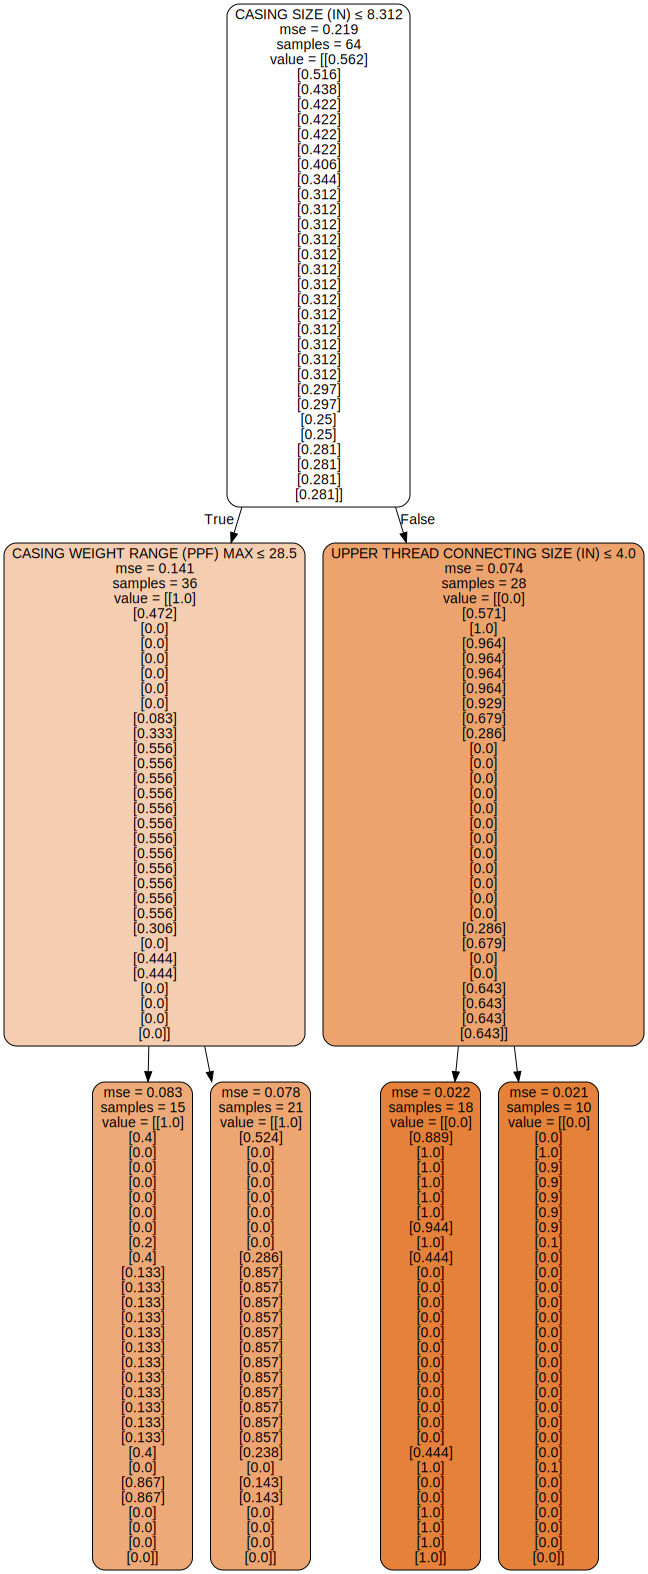

In [17]:
# Build multivariable decision tree (regression)

num_of_parts = 30 # len(top_parts)

X = pd.get_dummies(ia_df_parsed.iloc[:,0:30].dropna())
y = ia_df_parsed.loc[X.index][list(top_parts[0:num_of_parts])].fillna(False).astype(int)

feature_names = [
    " ".join(x) if (x[1] != 'value' and len(x) == 2) else x if (len(x) > 2) else x[0] for x in X.columns
]

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=8)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)

kf = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores1 = cross_val_score(regr_1, X, y, cv=kf, scoring='r2')
print("Accuracy (max depth=2): {:0.2} (+/- {:0.2})".format(cv_scores1.mean(), cv_scores1.std() * 2))
cv_scores2 = cross_val_score(regr_2, X, y, cv=kf, scoring='r2')
print("Accuracy (max depth=5): {:0.2} (+/- {:0.2})".format(cv_scores2.mean(), cv_scores2.std() * 2))
cv_scores3 = cross_val_score(regr_3, X, y, cv=kf, scoring='r2')
print("Accuracy (max depth=8): {:0.2} (+/- {:0.2})".format(cv_scores3.mean(), cv_scores3.std() * 2))
display(
    graphviz.Source(
        tree.export_graphviz(
            regr_1,
            out_file=None, 
            feature_names=feature_names,
            filled=True, rounded=True,  
            special_characters=True
        )
    )
)

Classification accuracy: 1.0 (+/- 0.0)


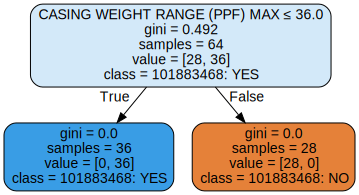

Classification accuracy: 1.0 (+/- 0.0)


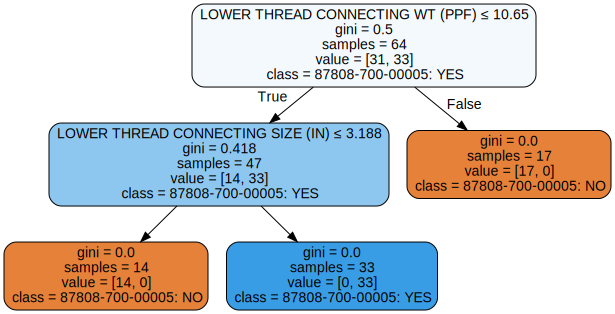

Classification accuracy: 1.0 (+/- 0.0)


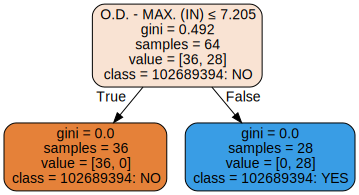

In [18]:
# Build decision tree model (binary classification)

classification_trees = []

for i in range(0,3):
    # binary class labels: part is either present in packers bom or not
    y_classification = ia_df_parsed.loc[X.index,top_parts[i]].fillna(False).astype(int)

    classification_tree = tree.DecisionTreeClassifier()
    classification_tree = classification_tree.fit(X, y_classification)

    classification_scores = cross_val_score(classification_tree, X, y_classification, cv=kf)
    print("Classification accuracy: {:0.2} (+/- {:0.2})".format(classification_scores.mean(), classification_scores.std() * 2))
    classification_trees.append(classification_tree)

    dot_data = tree.export_graphviz(
        classification_tree, 
        out_file=None, 
        feature_names=feature_names,
        class_names=["{}: NO".format(y_classification.name), "{}: YES".format(y_classification.name)],
        filled=True, rounded=True,  
        special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render("tree", format='png')
    display(graph)

In [19]:
r = tree.export.export_text(classification_trees[1], feature_names=feature_names)
print(r)

|--- LOWER THREAD CONNECTING WT (PPF) <= 10.65
|   |--- LOWER THREAD CONNECTING SIZE (IN) <= 3.19
|   |   |--- class: 0
|   |--- LOWER THREAD CONNECTING SIZE (IN) >  3.19
|   |   |--- class: 1
|--- LOWER THREAD CONNECTING WT (PPF) >  10.65
|   |--- class: 0



/Users/markpolyak/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/markpolyak/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


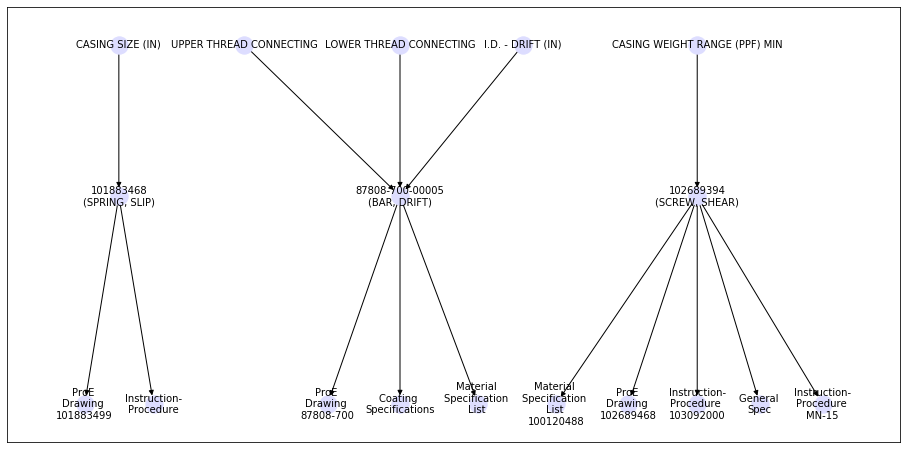

In [20]:
# Build a summary graph (by hand) and export it to Gephi
G = nx.DiGraph()
# IEAs
G.add_nodes_from([
    'CASING SIZE (IN)', 
    'UPPER THREAD CONNECTING', 
    'LOWER THREAD CONNECTING',
    'I.D. - DRIFT (IN)',
    'CASING WEIGHT RANGE (PPF) MIN',
])
# parts
G.add_nodes_from(['101883468', '87808-700-00005', '102689394'])
# relationship: IEAs -> BOM parts
G.add_edges_from([
    ('CASING SIZE (IN)', '101883468'), 
#     ('CASING SIZE (IN)', '87808-700-00005'), 
    ('UPPER THREAD CONNECTING', '87808-700-00005'), 
    ('LOWER THREAD CONNECTING', '87808-700-00005'),
    ('I.D. - DRIFT (IN)', '87808-700-00005'),
    ('CASING WEIGHT RANGE (PPF) MIN', '102689394'),
])

# part 101883468 details
G.add_nodes_from([
    'ProE \nDrawing \n101883499', 
    'Instruction-\nProcedure', 
])
G.add_edges_from([
    ('101883468', 'ProE \nDrawing \n101883499'), 
    ('101883468', 'Instruction-\nProcedure'), 
])

# part 87808-700-00005 details
G.add_nodes_from([
    'ProE \nDrawing \n87808-700', 
    'Coating \nSpecifications', 
    'Material \nSpecification \nList \n'
])
G.add_edges_from([
    ('87808-700-00005', 'ProE \nDrawing \n87808-700'), 
    ('87808-700-00005', 'Coating \nSpecifications'), 
    ('87808-700-00005', 'Material \nSpecification \nList \n')
])

# part 102689394 details
G.add_nodes_from([
    'Material \nSpecification \nList \n100120488',
    'ProE \nDrawing \n102689468',
    'Instruction-\nProcedure \n103092000',
    'General \nSpec',
    'Instruction-\nProcedure \nMN-15',    
])
G.add_edges_from([
    ('102689394', 'Material \nSpecification \nList \n100120488'),
    ('102689394', 'ProE \nDrawing \n102689468'), 
    ('102689394', 'Instruction-\nProcedure \n103092000'), 
    ('102689394', 'General \nSpec'), 
    ('102689394', 'Instruction-\nProcedure \nMN-15'), 
])

# add some line breaks to long names
relable_mapping = {
    '101883468': '101883468\n(SPRING, SLIP)',
    '87808-700-00005': '87808-700-00005\n(BAR, DRIFT)',
    '102689394': '102689394\n(SCREW, SHEAR)'
}



nx.relabel_nodes(G, relable_mapping, copy=False)
# export to Gephi
nx.write_gexf(G, 'map.gexf')
# use graphviz to calculate positions of nodes (it works better than networkx default positioning algorithm)
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

# add more space between nodes
# i = 1
# for node in pos:
#     pos[node] = (pos[node][0]*1.2, pos[node][1])
#     i *= 1.5

# plot with pyplot
plt.figure(1, figsize=(16, 8))
nx.draw_networkx(G, pos=pos, with_labels=True, node_color='#ddddff', font_size=10) # node_color='#75daff'
plt.savefig('graph.png')

101883468
Classification accuracy: 1.0 (+/- 0.0)
Classification precision: 1.0 (+/- 0.0): [1. 1. 1. 1. 1. 1. 1. 1.]
Classification recall: 1.0 (+/- 0.0): [1. 1. 1. 1. 1. 1. 1. 1.]
87808-700-00005
Classification accuracy: 1.0 (+/- 0.0)
Classification precision: 1.0 (+/- 0.0): [1. 1. 1. 1. 1. 1. 1. 1.]
Classification recall: 1.0 (+/- 0.0): [1. 1. 1. 1. 1. 1. 1. 1.]
102689394
Classification accuracy: 1.0 (+/- 0.0)
Classification precision: 1.0 (+/- 0.0): [1. 1. 1. 1. 1. 1. 1. 1.]
Classification recall: 1.0 (+/- 0.0): [1. 1. 1. 1. 1. 1. 1. 1.]
102872569
Classification accuracy: 0.98 (+/- 0.083)
Classification precision: 0.97 (+/- 0.17): [1.   1.   0.75 1.   1.   1.   1.   1.  ]
Classification recall: 1.0 (+/- 0.0): [1. 1. 1. 1. 1. 1. 1. 1.]
101986057
Classification accuracy: 0.98 (+/- 0.083)
Classification precision: 0.97 (+/- 0.17): [1.   1.   0.75 1.   1.   1.   1.   1.  ]
Classification recall: 1.0 (+/- 0.0): [1. 1. 1. 1. 1. 1. 1. 1.]
102876648
Classification accuracy: 0.97 (+/- 0.11)
C

/Users/markpolyak/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


88801-350
Classification accuracy: 0.88 (+/- 0.12)
Classification precision: 0.82 (+/- 0.65): [0.8  0.   1.   1.   1.   0.75 1.   1.  ]
Classification recall: 0.74 (+/- 0.66): [1.         0.         0.66666667 1.         0.75       1.
 0.5        1.        ]
102689395
Classification accuracy: 0.98 (+/- 0.083)
Classification precision: 1.0 (+/- 0.0): [1. 1. 1. 1. 1. 1. 1. 1.]
Classification recall: 0.96 (+/- 0.22): [1.         1.         0.66666667 1.         1.         1.
 1.         1.        ]
102044817
Classification accuracy: 0.94 (+/- 0.12)
Classification precision: 0.94 (+/- 0.33): [1.  1.  0.5 1.  1.  1.  1.  1. ]
Classification recall: 0.89 (+/- 0.3): [1.         1.         1.         1.         0.66666667 1.
 0.75       0.66666667]
101884444
Classification accuracy: 0.94 (+/- 0.12)
Classification precision: 0.94 (+/- 0.33): [1.  1.  0.5 1.  1.  1.  1.  1. ]
Classification recall: 0.89 (+/- 0.3): [1.         1.         1.         1.         0.66666667 1.
 0.75       0.66666667]

/Users/markpolyak/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


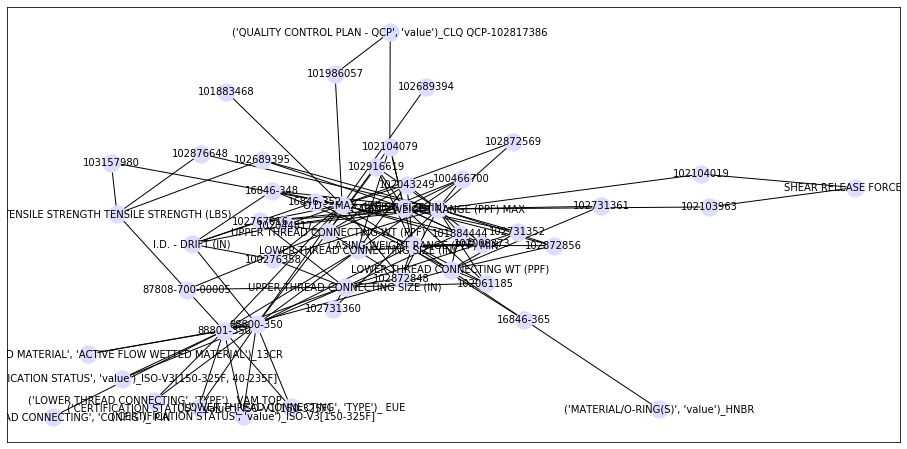

In [21]:
from sklearn.tree import _tree

G1 = nx.Graph()
kf = KFold(n_splits=8, shuffle=False, random_state=42)

accuracy = np.array([])
precision = np.array([])
recall = np.array([])

for repeat_count in range(0,1):
    for i in range(0,len(y.columns)):
        # Initialize our decision tree object
        classification_tree = tree.DecisionTreeClassifier()
        # Train our decision tree (tree induction + pruning)
#         y_classification = y.iloc[:,i]
        y_classification = ia_df_parsed.loc[X.index,top_parts[i]].fillna(False).astype(int)
        class_names = ["{}: NO".format(y_classification.name), "{}: YES".format(y_classification.name)]
        classification_tree = classification_tree.fit(X, y_classification)
        classification_scores = cross_val_score(classification_tree, X, y_classification, cv=kf)
        precision_scores = cross_val_score(classification_tree, X, y_classification, cv=kf, scoring='precision')
        recall_scores = cross_val_score(classification_tree, X, y_classification, cv=kf, scoring='recall')
        print(y_classification.name)
        print("Classification accuracy: {:0.2} (+/- {:0.2})".format(classification_scores.mean(), classification_scores.std() * 2))
        print("Classification precision: {:0.2} (+/- {:0.2}): {}".format(precision_scores.mean(), precision_scores.std() * 2, precision_scores))
        print("Classification recall: {:0.2} (+/- {:0.2}): {}".format(recall_scores.mean(), recall_scores.std() * 2, recall_scores))
        accuracy  = np.append(accuracy, classification_scores.mean())
        precision = np.append(precision, precision_scores.mean())
        recall = np.append(recall, recall_scores.mean())

        # prepare tree graph
        dot_data = tree.export_graphviz(
            classification_tree, 
            out_file=None, 
            feature_names=feature_names,
            class_names=class_names,
            filled=True, rounded=True,  
            special_characters=True)
        graph = graphviz.Source(dot_data)
        graph.render("tree_{}".format(i), format='png')
        # parse tree
        r = tree.export.export_text(classification_tree, feature_names=feature_names)
        tree_features = [
            feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in classification_tree.tree_.feature
        ]
        unique_features = set(tree_features)-set(['undefined!'])
        G1.add_node(y_classification.name)
        G1.add_nodes_from(unique_features)
        for f in unique_features:
            G1.add_edge(f, y_classification.name)


plt.figure(3,figsize=(16,8))
nx.draw_networkx(G1, with_labels=True, node_color='#ddddff', font_size=10) # #75daff
plt.savefig('graph_big.png', dpi=200)

In [22]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature
    ]
#     print("def tree({}):".format(", ".join(feature_names)))
#     print("")
#     print(feature_name)

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if '{}' <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if '{}' > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

tree_to_code(classification_trees[1], feature_names)

  if LOWER THREAD CONNECTING WT (PPF) <= 10.650000095367432:
    if LOWER THREAD CONNECTING SIZE (IN) <= 3.1875:
      return [[14.  0.]]
    else:  # if LOWER THREAD CONNECTING SIZE (IN) > 3.1875
      return [[ 0. 33.]]
  else:  # if LOWER THREAD CONNECTING WT (PPF) > 10.650000095367432
    return [[17.  0.]]
